## 说明

本学期的任务是以**传统机器学习(ML)方法**及**深度学习(DL)方法**完成京东商品的情感分析系统，之前已经完成了机器学习(k-近邻算法、逻辑回归、朴素贝叶斯、决策树、随机森林、支持向量机、简单多层感知机)对京东评论的**分类效果(好坏)**，如有兴趣可参考这两篇文章[评论情感分析----多种机器学习模型测试总结](https://blog.csdn.net/weixin_43479947/article/details/126940752)和[朴素贝叶斯算法----评论情感分析系统](https://blog.csdn.net/weixin_43479947/article/details/126730761)。

现在来一步步实现深度学习模型 **Recurrent Neural Net (RNN)** 对情感分析的效果，且本次是三分类目标，即差中好评。

## 思路

此次的 RNN 实现耗费了我2.3天的时间，在网上看了好些文章，终于搞定，重要的是思路，思路，思路！(重要的事情说三遍)


RNN 实现文本分类的步骤为以下几步:

1、**读取训练数据集(7200条随机排列数据)、测试数据集(4800条随机排列数据)**，样本的形式为-->(评论原文、标签(1,2,3)、预处理后的评论(空格分隔))。

2、根据预处理后的评论生成 **tokens 列表**，即 [['手机'， '不错']，['充电'， '很慢']，[''，'']，，，] 这样的二维数组，列表每一个元素即一个评论分词列表。

3、**Word2Vec 词向量化**，将tokens投入Word2Vec模型，生成每一个词语对应的向量(一般100~300维)，并生成对应词典 id_token_voc，即['手机','性能',,]等。

4、根据字典 id_token_voc 将评论 tokens 转化为其对应的索引下标 **tokens_index**，即[[0,545,264][1,4,854],,,]这样的二维数组，并**生成训练集与测试集列表**。

5、**构建 RNN 模型**，主要由 3 个部分构成，词嵌入矩阵Embedding、循环隐藏层RNN、全连接层Linear。

6、定义**梯度裁剪函数clip**，限制梯度的过度增长，防止梯度爆炸。

7、**初始化模型参数，选择损失函数、模型优化器、学习率、迭代次数等**。

8、定义模型训练函数与评估函数，**预测评估**。

具体的实现细节如下。

### Step1：读取数据集

读取训练集与测试集的数据，好中差评各4000个，分别以3、2、1标签标识。

In [1]:
import csv

#传入训练集与测试集的文件名路径
def read_comments(train_file, test_file):
    train_array, test_array = [], []
    
    with open(train_file, 'r', encoding='UTF-8') as fp_train:
        reader_train = csv.reader(fp_train)
        train_array = [line for line in reader_train]                      #读取训练集所有数据
    
    with open(test_file, 'r', encoding='UTF-8') as fp_test:
        reader_test = csv.reader(fp_test)
        test_array = [line for line in reader_test]                        #读取测试集所有数据

    return train_array, test_array

In [2]:
train_array, test_array = read_comments('./RedMi_Comments_Train.csv', './RedMi_Comments_Test.csv')

查看读取到的信息，训练集测试集长度，训练集与测试集的前3个数据。

In [3]:
len(train_array), len(test_array), train_array[:3], test_array[:3]

(7200,
 4800,
 [['手机绿屏问题严重，外观可以，质量问题耽误了很长时间，不过已经退货了，所以勉强中评吧。',
   '2',
   '手机 绿屏 外观 质量 耽误 长时间 退货 勉强 中评'],
  ['明明写的是双卡双待， 咋拿到手是单卡呢？', '1', '明明 写 双卡 双待 拿到 手是 单卡'],
  ['刷视频会偶尔卡一下 还有绿屏', '2', '刷 视频 卡 绿屏']],
 [['耗电快  触屏不灵敏', '2', '耗电 触屏 不灵敏'],
  ['体验感真的非常一般，打一把吃鸡卡的一顿一顿的，玩起来是手机那种卡而不是网卡。',
   '2',
   '体验 感 真的 一把 吃 鸡卡 一顿 一顿 玩起来 手机 那种 卡而 网卡'],
  ['真心喜欢，颜色、款式都非常棒！手机性能很好，使用很流畅，黑色也很显大气',
   '3',
   '真心 喜欢 颜色 款式 棒 手机 性能 流畅 黑色 显 大气']])

可以看到，每条样本的形状均是-->(评论原文、标签(1,2,3)、预处理后的评论(空格分隔))。

### Step2：生成 tokens 数组

生成 tokens 数组要将训练集与测试集的所有评论信息进行**汇总生成**，否则 tokens 数据不健壮，预测时发生异常。

In [7]:
def create_tokens(train_array, test_array):
    
    tokens = []
    
    #追加训练集的tokens
    for comment_data in train_array:
        tokens.append(comment_data[2].split(' '))
        
    #追加测试集的tokens
    for comment_data in test_array:
        tokens.append(comment_data[2].split(' '))
    
    return tokens                      #返回数据集的所有tokens

获取数据集的所有tokens

In [8]:
tokens = create_tokens(train_array, test_array)

打印前 3 条评论的 tokens

In [9]:
tokens[:3]

[['手机', '绿屏', '外观', '质量', '耽误', '长时间', '退货', '勉强', '中评'],
 ['明明', '写', '双卡', '双待', '拿到', '手是', '单卡'],
 ['刷', '视频', '卡', '绿屏']]

### Step3：使用Word2Vec生成词向量

我们知道，在神经网络中，网络的输入和输出一般均为数值型数据，且多数为**向量矩阵操作**，所以我们使用 Word2Vec 对评论中的每个词语进行编码。

In [12]:
from gensim.models import Word2Vec

def word_vec(tokens):
    
    #调用Word2Vec模型，将所有词语信息转化为向量
    model = Word2Vec(tokens, sg=0, vector_size=300, window=5, min_count=1, epochs=7, negative=10)
    model.save('word2vec_model')
    
    return model

进行单词的编码操作。

In [13]:
word_vecs = word_vec(tokens=tokens)

输出词向量后的信息。

In [17]:
print(word_vecs.wv.vectors.shape)                                    #输出所有向量总的形状
print(word_vecs.wv.index_to_key[:5])                                 #所有的词表信息['word1', 'word2', ,,,]，输出前5个
print(word_vecs.wv.vectors[:5])                                      #输出前5个词对应的向量信息，并输出总的形状

(12290, 300)
['手机', '屏幕', '速度', '买', '拍照']
[[ 0.22328758  0.4189271   0.35290527 ... -0.09952404  0.41498646
  -0.2528276 ]
 [-0.64310986  1.0110681   0.5830663  ...  0.14262454  0.16716707
  -0.38810295]
 [ 0.11316339 -0.21425752 -0.05783952 ...  0.40457097  0.07221112
  -0.40334523]
 [ 0.01772678  0.03810279 -0.3342527  ... -0.6968465   0.41878763
  -0.38556474]
 [-0.70590377  0.17386001  0.36469993 ...  0.41195953  0.07781225
  -0.15701027]]


可见，存在12290个词语，每个词语均使用300维(长度)的向量来表示。

此时，也应生成该向量矩阵对应的词典，用于将所有评论句子内的**词语信息**转化为**向量索引**。

In [18]:
id_token_voc = word_vecs.wv.index_to_key

输出字典内的前 10 个词语：

In [19]:
id_token_voc[:10]

['手机', '屏幕', '速度', '买', '拍照', '运行', '不错', '外观', '效果', '小米']

### Step4：将 tokens 内的词语转化为向量索引

In [20]:
def word_to_idx(tokens, id_token_voc):
    tokens_index = []
    
    for sentence in tokens:                                #遍历所有评论
        index = []
        for word in sentence:
            index.append(id_token_voc.index(word))         #将每个单词转化为字典对应的索引
        tokens_index.append(index)
    
    return tokens_index                                   #返回所有评论的索引列表

将所有评论词语转化为向量索引:

In [21]:
tokens_index = word_to_idx(tokens, id_token_voc)

输出前两个评论的 tokens 索引列表:

In [24]:
tokens_index[:2]

[[0, 454, 7, 60, 907, 819, 139, 1048, 1997],
 [922, 793, 1589, 3052, 116, 8322, 5442]]

并输出这两条评论对应的文本信息:

In [27]:
[id_token_voc[id] for id in tokens_index[0]], [id_token_voc[id] for id in tokens_index[1]]

(['手机', '绿屏', '外观', '质量', '耽误', '长时间', '退货', '勉强', '中评'],
 ['明明', '写', '双卡', '双待', '拿到', '手是', '单卡'])

可见，句子是正确有逻辑的，所以 tokens_index 评论词语索引列表生成正确。

### Step5：生成训练集与测试集

同样地，我们将生成训练集和测试集的数据迭代器，每一个样本均包含对应的评论索引列表和其对应的标签。如下

In [54]:
#生成训练集与测试集的数据迭代器
def get_iter(train_array, test_array, tokens_index):
    train_iter = [[torch.tensor(tokens_index[i]), torch.tensor(int(train_array[i][1]))] for i in range(len(train_array))]
    test_iter = [[torch.tensor(tokens_index[i+len(train_array)]), torch.tensor(int(test_array[i][1]))] for i in range(len(test_array))]
    return train_iter, test_iter


train_iter, test_iter = get_iter(train_array, test_array, tokens_index)

测试一下训练集与测试集的长度，以及训练集的前5个样本:

In [64]:
len(train_iter), len(test_iter), train_iter[:5]

(7200,
 4800,
 [[tensor([   0,  454,    7,   60,  907,  819,  139, 1048, 1997]), tensor(2)],
  [tensor([ 922,  793, 1589, 3052,  116, 8322, 5442]), tensor(1)],
  [tensor([234,  46,  38, 454]), tensor(2)],
  [tensor([5367, 1601, 3101, 5481,  155,  587, 4605, 5214, 1624,  570,    6,  189,
            148,    4,   24, 1367,  342,   28,    5,   13,  119,   31]),
   tensor(3)],
  [tensor([8364,  804,  957,  184,  463,  120,   29,  163,   46,   54,    5,   13,
            438,   24, 1949,  342,  287]),
   tensor(3)]])

符合预期，创建成功。

### Step6：构建RNN循环神经模型

要想更加本质的理解这一部分的内容，我想还是应该把 RNN 的图示和计算公式贴在这里，更能方便大家理解。

RNN的**核心公式**如下。

隐状态 $H$:

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

输出结果 $O$:

$$O_{t} = H_{t}W_{hq} + b_q$$

其中，添加了 ${H}_{t-1}$ 代表上个时序**隐状态**，${W}_{hh}$ 代表了其对应的**权重矩阵**, $O_{t}$代表**时间段t的输出**。

图示如下:

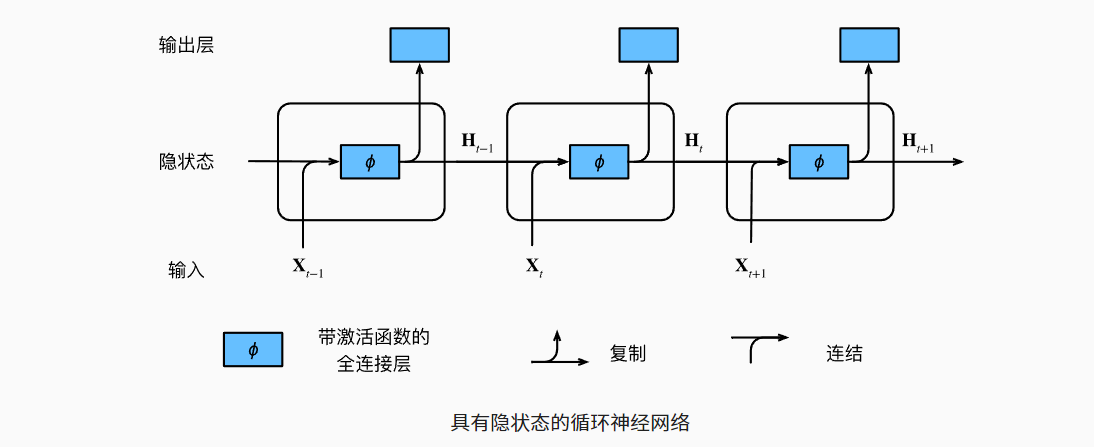

由此可见，要想使用 RNN 网络预测得到结果，我们大体上需要两个部分组成：**RNN层(生成最终隐状态 $H$ )、Linear全连接层(生成结果 $O$)**。

但是我们又需要将所有评论语句变为向量投入到网络中，所以还需要一部分**Embedding词嵌入**模型，用于将所有的评论信息转化为矩阵信息，所以共需要三部分构成。下面来定义RNN模型：

In [34]:
import torch
from torch import nn

class RNNModel(nn.Module):
    
    #初始化模型
    def __init__(self, id_token_voc, embedding_dim, hidden_dim, output_dim, vectors):
        super(RNNModel, self).__init__()
        
        #生成词嵌入的矩阵
        self.embedding = nn.Embedding(len(id_token_voc), embedding_dim)
        self.embedding = self.embedding.from_pretrained(torch.tensor(vectors))
        
        #RNN循环隐藏层，计算出最后的H隐状态
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        #Linear全连接层，用于输出最后的分类结果概率
        self.liner = nn.Linear(hidden_dim, output_dim)

    #前向传播函数，计算分类结果
    def forward(self, X):
        
        #将X评论语句的词语索引均转化为对应的向量
        #此时的embedded的形状为 (评论长度(词语个数)、批量数目、词向量维度)
        #因为我们之前并未统一评论的长度，不能够批量训练样本数据、所以此次训练批量数目均为1
        embedded = self.embedding(X.T.long())
        
        #RNN层计算出隐状态列表(h_1, h_2, ,,, h_n)
        #其中 out 代表所有时间步 t_i 的隐状态(h_1, h_2, ,,, h_n)
        #其中 h 代表最后一个时间步的隐状态 h_n
        #out.shape(评论长度(词语个数)、批量数目、隐单元维度)、h.shape(1, 批量数目，隐单元维度)，注意本文章的批量数目均为1
        out, h = self.rnn(embedded)
        
        #断言最后一个隐状态h_n是否等于h_n
        #h.squeeze()方法为压缩维度，将第0个维度取出，即h.squeeze(0).shpae = (批量数目1，隐单元维度)
        assert torch.equal(out[-1, :, ], h.squeeze(0))

        #最后通过全连接层计算结果Out，并以softmax()回归规范数据
        return F.softmax(self.liner(h.squeeze(0)))

### Step7：定义梯度裁剪方法

梯度裁剪，顾名思义，就是对梯度进行限制，防止出现**梯度爆炸**的情况，以免影响模型训练。

具体的裁剪方法如下公式所示:

$$g \leftarrow min(1, \frac{\theta}{||g||})g$$

其中， $||g||$代表**梯度的二范数**, $\theta$ 代表**设定范围**。

In [35]:
def grad_clipping(net, theta):  # @save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))      #计算梯度的二范数
    
    if norm > theta:                                                      #如果梯度的二范数大于设定值时，进行梯度裁剪操作
        for param in params:
            param.grad[:] *= theta / norm

### Step8：初始化模型参数、损失函数、优化算法

现在，我们来实例化RNN模型，并初始化模型参数。

In [37]:
from d2l import torch as d2l

#初始化模型参数函数，均为正态分布
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.RNN:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

#实例化模型并初始化模型参数，并尝试使用gpu进行训练
net = RNNModel(id_token_voc=id_token_voc, embedding_dim=300, hidden_dim=256, output_dim=3, vectors=word_vecs.wv.vectors)
net.apply(init_weights)
net = net.to(d2l.try_gpu())

#设置词嵌入矩阵不计入梯度的计算
net.embedding.weight.requires_grad = False

#定义交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

#定义梯度下降方法优化器
updater = torch.optim.SGD(net.parameters(), 0.0001)

### Step9：定义训练模型函数，训练模型

现在，我们需要定义训练函数，从而对模型进行训练。

首先定义一个评估函数，每次迭代一次后均要评测模型对训练集与测试集的精确度。

In [65]:
def evaluate_net(net, train_iter, test_iter, device):
    
    correct_train = 0
    correct_test = 0
    error_train = 0
    error_test = 0
    
    #统计训练集的预测正确与预测错误的数目
    for X, y in train_iter:
        
        X = X.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_hat = net(X)
        
        if y_hat.argmax().item() + 1 == y.item():
            correct_train += 1
        else:
            error_train += 1
    
    #统计测试集的预测正确与预测错误的数目
    for X, y in test_iter:
        
        X = X.unsqueeze(0)
        
        X = X.to(device)
        y = y.to(device)
        
        y_hat = net(X)
        
        if y_hat.argmax().item() + 1 == y.item():
            correct_test += 1
        else:
            error_test += 1
    
    #返回模型在训练集与测试集上的准确度
    return correct_train/len(train_iter), correct_test/len(test_iter)
    

现在来定义训练函数。

In [66]:
def train(net, train_iter, test_iter, loss, updater, num_epochs, device):
    print('----------开始训练----------')
    
    
    for i in range(num_epochs):        #共迭代num_epochs次
        
        num = 0
        loss_sum = 0     
        
        for X, Y in train_iter:
            
            X = X.unsqueeze(0)         #增加一个维度，表示批量大小为1， 此时X的形状为(1, 词语个数(序列索引))
            
            X = X.to(device)
            y = y.to(device)
            
            y_hat = net(X)            #通过RNN循环神经网络预测y_hat, 会返回(1, 3)的概率列表，表示三个类别的概率分布
            
            updater.zero_grad()       #清空梯度
            
            #之所以(y-1).long() 是因为y代表的是标签123，并不是概率列表下标012，所以要 (y-1)将标签换做成下标计算损失
            l = loss(y_hat, (y-1).long())
            
            l.backward()             #后向传播计算梯度，更新模型参数
            updater.step()
            
            grad_clipping(net, 1)    #进行梯度裁剪
            
            num += 1                 #训练样本个数累加
            loss_sum += l            #训练损失累加
        
        
        train_acc, test_acc = evaluate_net(net, train_iter, test_iter, device)
        
        #输出迭代次数、损失、训练集准确度、测试集准确度
        print('-epochs:', (i+1),  '\t-loss:', loss_sum/num, '\t-train-acc:', train_acc, '\t-test-acc:', test_acc)
        
    
    #保存模型参数，方便下次使用时直接进行加载
    torch.save(net.state_dict(), 'RNN.parameters')        

### Step10：训练和评估模型

In [68]:
train(net, train_iter, test_iter, loss, updater, 50, d2l.try_gpu)

由下图的运行结果可见，随着损失的不断减少，训练集与预测集的准确准确度也在不断提高。

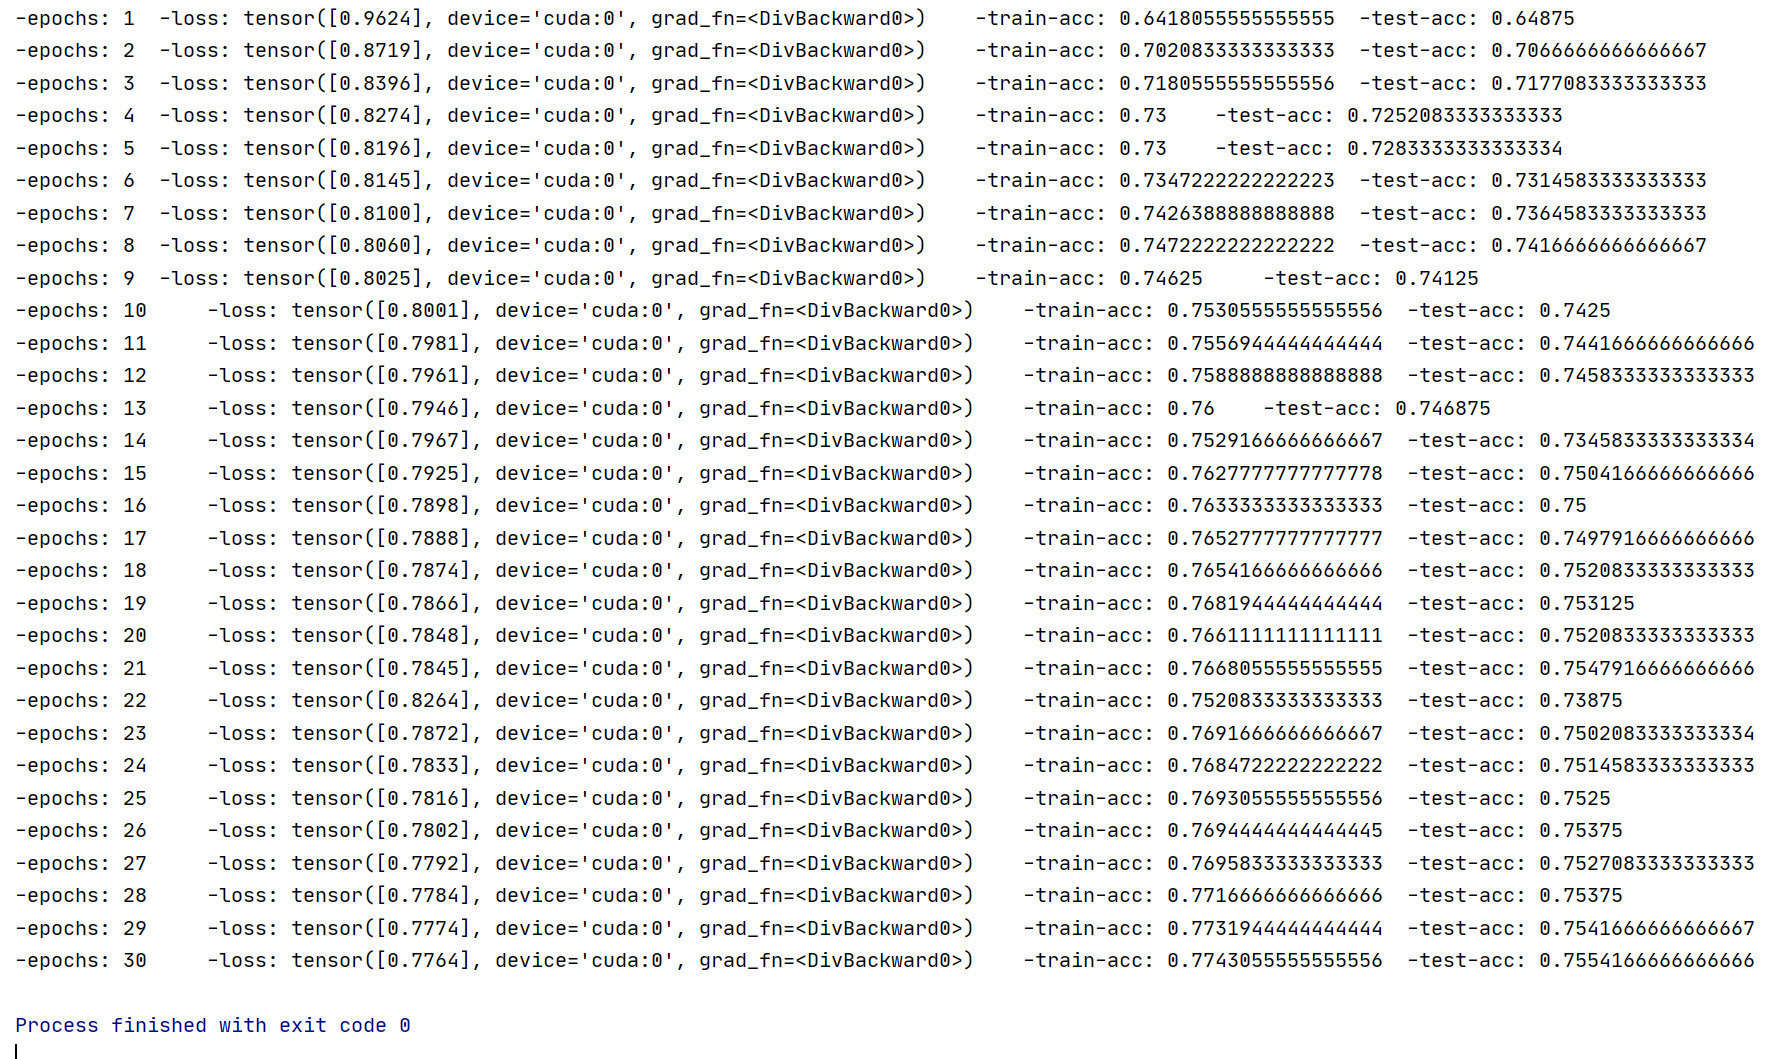

但是随着迭代次数的不断增加，测试集的准确度会稳定在75%左右，而训练集的准确度能够达到80%左右。

说明该模型仍有可以改进的地方，我们可以**适当添加多层全连接层**、使用**不同的优化方法、损失函数**等方式提高模型准确度，有兴趣的小伙伴们可以自行尝试。

### 情感预测分类

看了前面那么多，可能都看累了，现在让我们利用训练好的模型预测一下京东评论的情感吧。

In [69]:
#加载已经保存的模型参数
net.load_state_dict(torch.load('./RNN.parameters'))
device = d2l.try_gpu()

for X, y in test_iter[:20]:            #对测试集的前20个样本进行测试


    X = X.to(device)
    y = y.to(device)

    #输出样本的评论语句信息
    print(' '.join([id_token_voc[i] for i in X]))

    X = X.unsqueeze(0)
    y_hat = net(X)

    print('-预测类别:', y_hat.argmax().item() + 1 ,'\t-实际类别:', y.item(), end='\t')

    if y_hat.argmax().item() + 1 == y.item():
        print('\t-预测正确\n')

    else:
        print('\t-预测错误\n')

部分运行结果如下图:

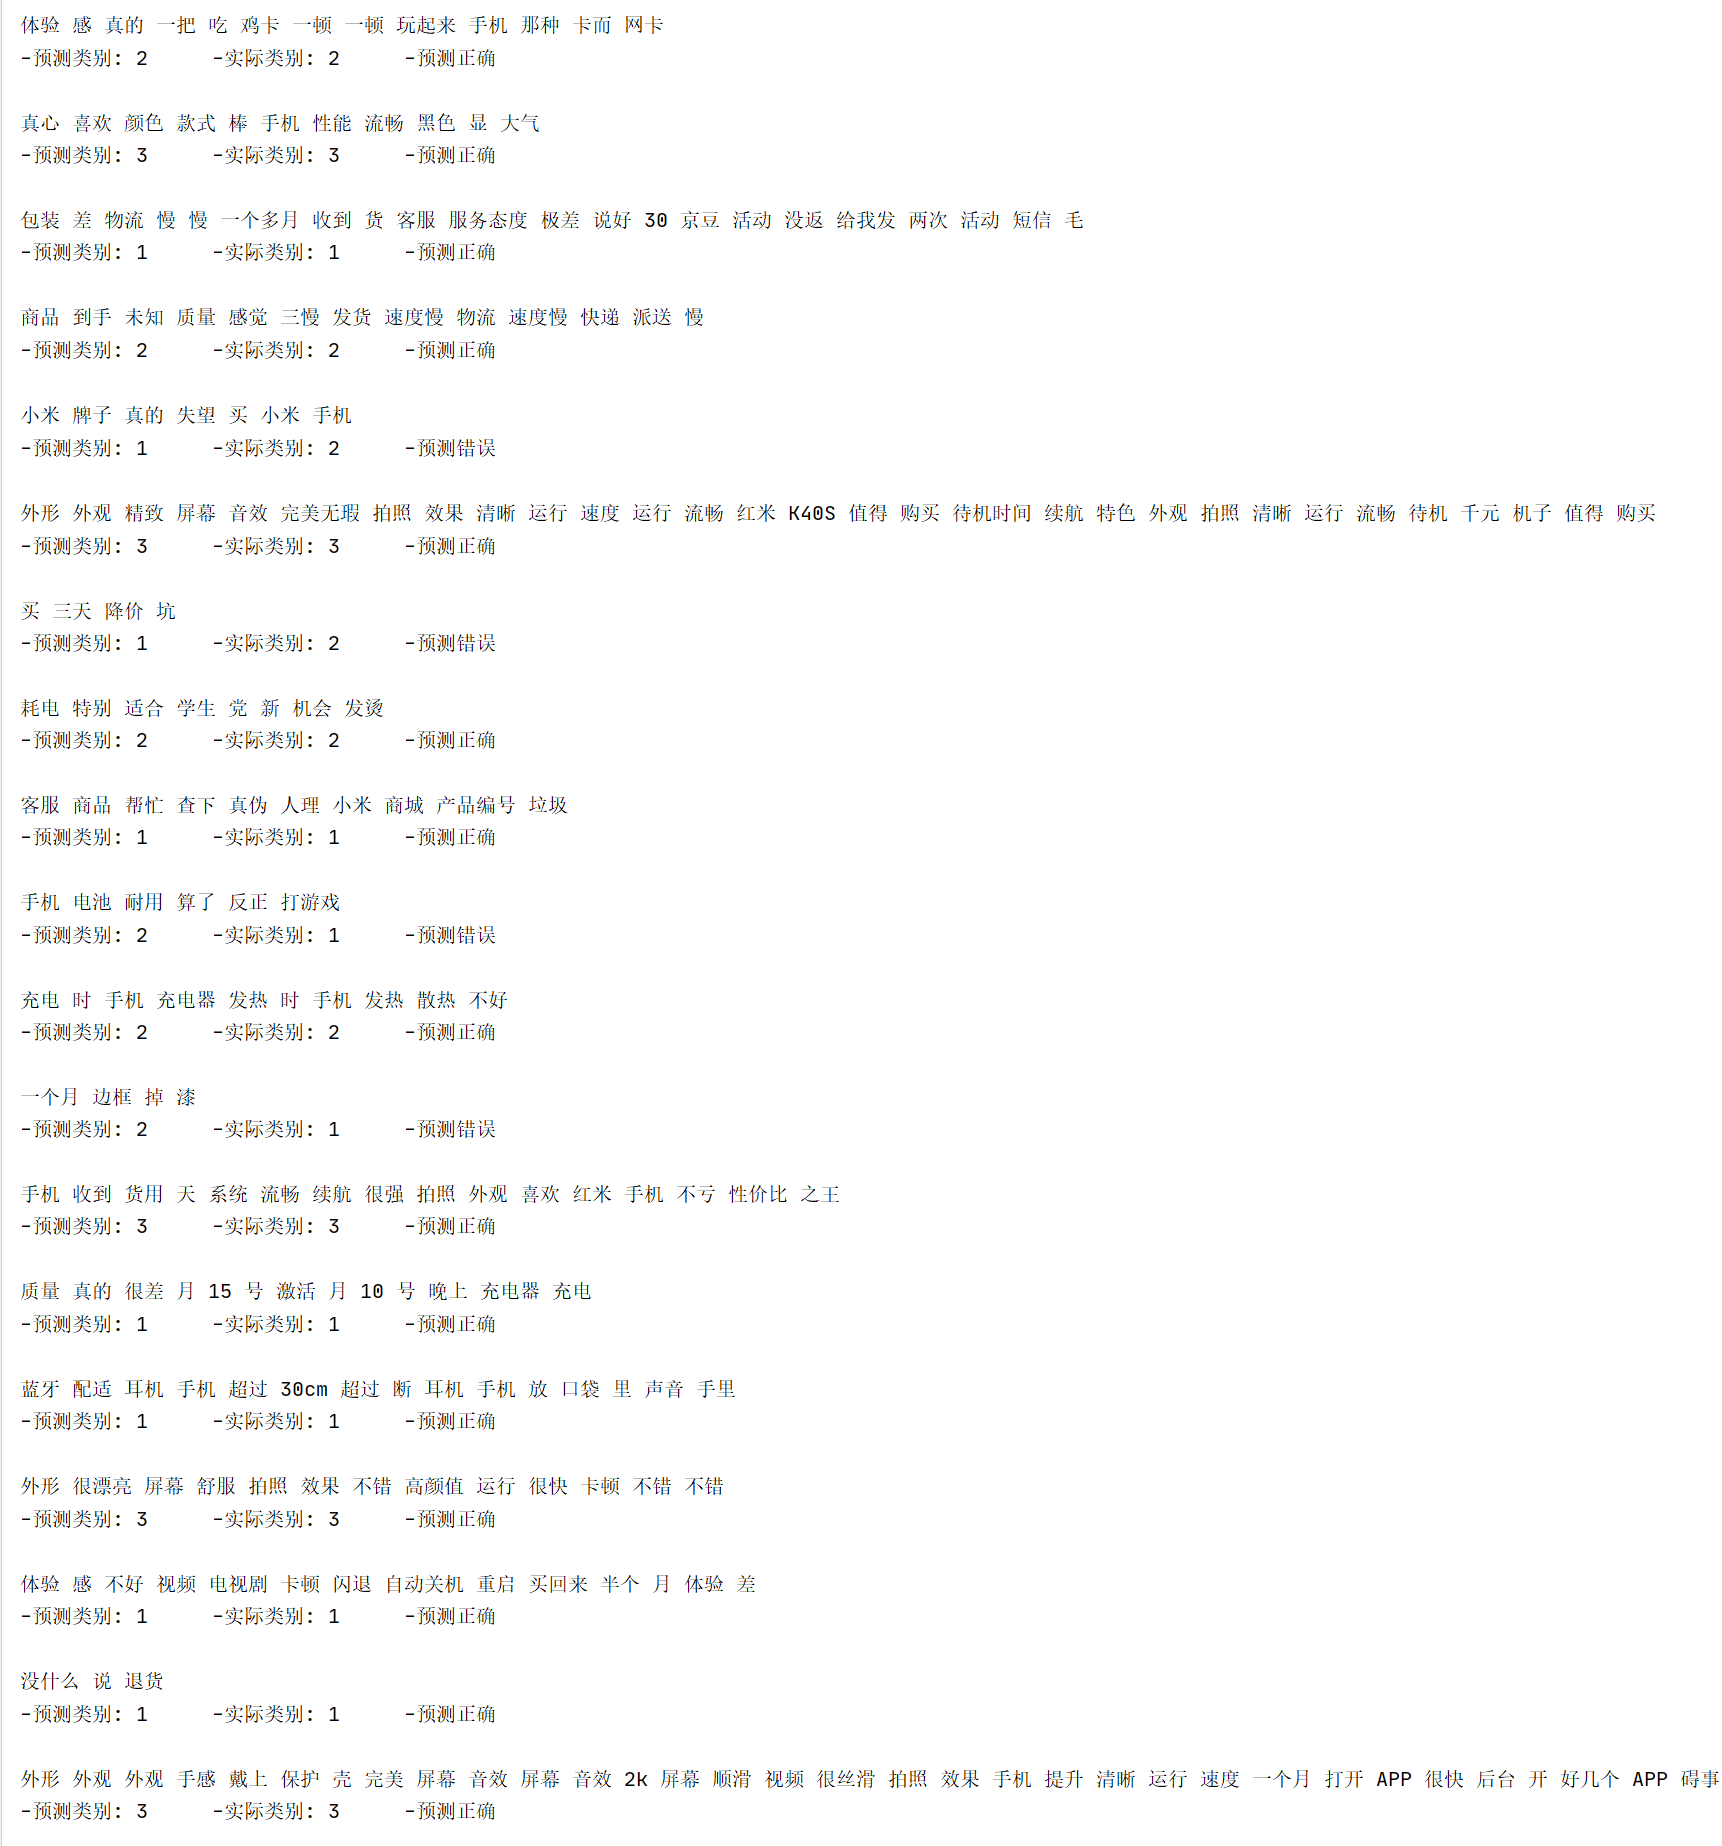

### 小结

本次 RNN 实现的京东情感分析分类，仍有许多不足，望有时间进行改进。主要有以下几点：

1、模型使用了纯正的 RNN 模型思想实现，未进行改进或者升级（可以尝试改进版GRU或LSTM等）。

2、训练集与测试集的生成不是特别规范，有待改进。

3、最重要的一点**未采用多批量训练，仅采用单批量训练，导致模型训练速度过慢**。(可以通过**填充或裁剪**的方法，使所有评论的词语序列长度一致)

4、仅使用了梯度下降的方法优化模型，也可尝试Adam()和其它优化方法。

5、数据集较小，使用较大的数据集训练的模型可能更加稳定。

有机会的话会逐渐更新优化该任务，加油。